## Dyna-Q: Integrating Learning and Planning

Here is the implementation of tabular Dyna-Q algorithm. Algorithm is run on following environments from openai.gym:
- CliffWalking-v0

In [0]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import sys
import gym
from gym import logger as gymlogger
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

## CliffWalking environment

- A state in the current position in 12x4 grid
- Action is one of 4 possible directions left,right,up,down

In [2]:
env = gym.make("CliffWalking-v0")
print(env.observation_space)
print(env.action_space)

Discrete(48)
Discrete(4)


## Dyna-Q Implementation

In [0]:
def get_epsilon_greedy_policy(env, q_values, epsilon=0.1):
    """
    Make an epsilon-greedy policy from given Q-values

    Returns:
        policy: epsilon-greedy policy which takes random action with
                probability epsilon/num_actions, otherwise takes
                greedy action
    """
    num_actions = env.action_space.n

    def policy(state):
        if state not in q_values:
            return np.ones((num_actions), dtype=float) / num_actions
        greedy_action = q_values[state].argmax()
        action_probs = np.ones((num_actions)) * (epsilon/num_actions)
        action_probs[greedy_action] += 1-epsilon
        return action_probs
    
    return policy

In [0]:
def dyna_q(env, num_episodes=100, gamma=1.0, alpha=0.015, epsilon=0.1, planning_steps=10):
    """
    Implementation of Dyna-Q agent

    Args:
        env: Learning enviroment, e.g. Blackjack
        num_episodes: Number of episodes to run
        gamma: Discount factor
        alpha: Step size / learning rate
        epsilon: Epsilon to be used for making epsilon-greedy policy
        planning_steps: Number of steps to plan
    Returns:
        q_values: dictionary mapping states (tuple) to array of action values
                  i.e. s -> np.array([q(s,a1),q(s,a2),...])
        policy: the final (epsilon-)greedy policy
        stats: algorithm learning statistics
    """

    num_actions = env.action_space.n
    q_values = defaultdict(lambda: np.zeros(num_actions))
    policy = get_epsilon_greedy_policy(env, q_values, epsilon)
    model = {'actions': defaultdict(lambda: np.zeros(num_actions)),
             'rewards': defaultdict(float),
             'next_states': defaultdict(int),
             'done': defaultdict(bool)}
    stats = {'episode_lengths': [0 for _ in range(num_episodes)],
             'episode_returns': [0 for _ in range(num_episodes)]}
    
    episode_num = 0
    state = env.reset()
    done = False
    while True:
        print("\rEpisode {}/{} episodes".format(episode_num+1,num_episodes), end="")
        sys.stdout.flush()

        if done:
            state = env.reset()
            episode_num += 1

        if episode_num == num_episodes: break

        # Take action based on above policy
        action_probs = policy(state)
        action = np.random.choice(np.arange(num_actions), p=action_probs)
        next_state, reward, done, info = env.step(action)

        # Tabular Q-learning update
        next_action = np.argmax(policy(next_state))
        next_q_value = 0 if done else q_values[next_state][next_action]
        q_values[state][action] += alpha * (reward + gamma*next_q_value - q_values[state][action])

        # Update model
        model['actions'][state][action] += 1
        model['rewards'][(state,action)] = reward
        model['next_states'][(state,action)] = next_state
        model['done'][(state,action)] = done

        # Update stats
        stats['episode_returns'][episode_num] += reward
        stats['episode_lengths'][episode_num] += 1

        # Perform Planning
        for plan_step in range(planning_steps):
            plan_state = random.choice(list(model['actions'].keys()))
            plan_action_probs = model['actions'][state] / np.sum(model['actions'][state])
            plan_action = np.random.choice(np.arange(num_actions), p=plan_action_probs)
            plan_reward = model['rewards'][(plan_state, plan_action)]
            plan_next_state = model['next_states'][(plan_state, plan_action)]
            plan_done = model['done'][(plan_state, plan_action)]

            plan_next_action = np.argmax(policy(plan_next_state))
            plan_next_q_value = 0 if plan_done else q_values[plan_next_state][plan_next_action]
            q_values[plan_state][plan_action] += alpha * (plan_reward + gamma*plan_next_q_value - q_values[plan_state][plan_action])

        state = next_state
        
    policy = get_epsilon_greedy_policy(env, q_values, 0)
    return q_values, policy, stats

## Results on Cliff-Walking Environment

In [5]:
q_values_0, policy_0, stats_0 = dyna_q(env, num_episodes=1000, gamma=1.0, alpha=0.03, epsilon=0.01, planning_steps=0)
q_values_5, policy_5, stats_5 = dyna_q(env, num_episodes=1000, gamma=1.0, alpha=0.03, epsilon=0.01, planning_steps=5)
q_values_50, policy_50, stats_50 = dyna_q(env, num_episodes=1000, gamma=1.0, alpha=0.03, epsilon=0.01, planning_steps=50)

Episode 1000/1000 episodes

In [0]:
def plot_stats(all_stats, planning_steps):
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    for i,stats in enumerate(all_stats):
        episode_returns = pd.Series(stats['episode_returns']).rolling(50).mean()
        episode_lengths = pd.Series(stats['episode_lengths']).rolling(50).mean()
        ax1.plot(episode_returns, label="planning_steps={}".format(planning_steps[i]))
        ax2.plot(episode_lengths, label="planning_steps={}".format(planning_steps[i]))
    
    ax1.set_ylim((-80,0))
    ax1.set_title("Episode returns (smoothing window = 50)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total reward in Episode ")
    ax2.set_ylim((0,80))
    ax2.set_title("Episode lenghts (smoothing window = 50)")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Episode length")
    ax1.legend()
    ax2.legend()
    plt.show()

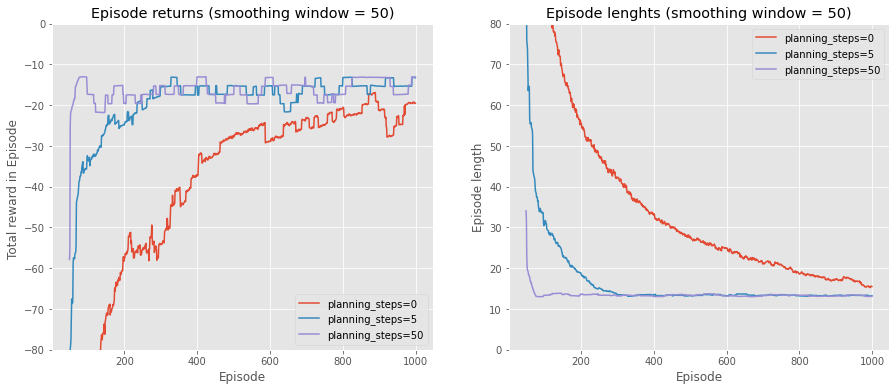

In [11]:
plot_stats([stats_0, stats_5, stats_50], [0,5,50])

### Effect of planning
Planning effect is pretty clear from the plots above. Whereas tabular Q-learning with no planning takes more than 1000 episodes to find optimum policy, Dyna-Q with only 5 steps of planning converges in about 300 episodes. If 50 planning steps were performed, the algorithm converges in just under 100 episodes.